## Learning to flow

This notebook shows how to wrap learnable flows into Keras using the **subclassing** `tf.keras.models.Model` to train then. It works with TF2.0 but I am not sure if this is the way to do it.

In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-rc0
        !pip install tensorflow-probability==0.8.0-rc0
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-rc0  running in colab?:  False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(1)
tf.random.set_seed(1)

TFP Version 0.8.0-rc0
TF  Version 2.0.0-rc0


### Learning Flows with TF 2.0

Let's create a flow using parameters, which can be learned. We use masked Autoregressive flows for that. 

dtype('float32')

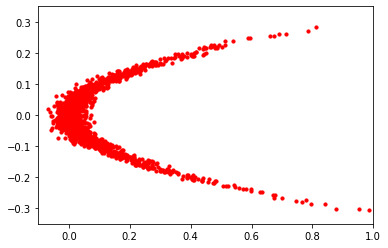

In [3]:
def sample(num):
    return np.array(np.random.uniform(-1,1,(num,2)), dtype='float32') #A real hard problem

# Adapted from: https://blog.evjang.com/2018/01/nf1.html
def sample_2(batch_size=500):
    x2_dist = tfd.Normal(loc=0., scale=4.)
    x2_samples = x2_dist.sample(batch_size)
    x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                    scale=tf.ones(batch_size, dtype=tf.float32))
    x1_samples = x1.sample()
    x_samples = tf.stack([x1_samples, x2_samples], axis=1)
    return x_samples.numpy()/40.0


X = sample_2(1500)
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)

X.dtype

### Makeing a Keras model

#### Subclassing a Keras model
We build our own model. As suggested in: https://www.tensorflow.org/beta/tutorials/quickstart/advanced we wrap the model into a Keras model class, by subclassing `tf.keras.models.Model`.


**Sometimes you start with Inf or NaN, run code serveral times?**

In [4]:
# See also https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/bijectors/real_nvp.py
from pylab import *
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

class RealNVP(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, **kwargs): #** additional arguments for the super class
        super().__init__(**kwargs)
        self.output_dim = output_dim
        # Defining the bijector
        bijectors=[]
        # We need to keep track of the nets
        self.nets = []
        h = 32
        for i in range(5):
            net = tfb.real_nvp_default_template(hidden_layers=[h, h])
            bijectors.append(tfb.RealNVP(shift_and_log_scale_fn=net,num_masked=num_masked))
            bijectors.append(tfb.Permute([1,0]))
            self.nets.append(net) 
        bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        
        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]),
            bijector=bijector)

    def call(self, *inputs): 
        return self.flow.bijector.forward(*inputs)
    

    
### Below is a bit magic stuff, concerning eager execution
model = RealNVP(output_dim=2, num_masked=1)
#model.summary() #Yields an error. The model needs called before it is build.
_ = model(X) 
print(model.summary())

##### Important
#Needs to be called other-wise @tf.function has problem
-tf.reduce_mean(model.flow.log_prob(X)) 

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Model: "real_nvp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 5,930
Trainable params: 5,930
Non-trainable params: 0
_________________________________________________________________
None


<tf.Tensor: id=1369, shape=(), dtype=float32, numpy=1.85814>

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function #Adding the tf.function makes it about 10-50 times faster!!!
def train_step(X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

In [6]:
from time import time
start = time()
for i in range(1001):
    #Xs = sample(1000) #Creat new training data
    loss = train_step(X)
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

0   1.85814 2.1748785972595215
100   -2.3713262 0.6232681274414062
200   -3.1256006 0.6586217880249023
300   -3.141074 0.6192216873168945
400   -3.1627984 0.6278254985809326
500   -3.161898 0.6323657035827637
600   -3.1688569 0.6427450180053711
700   -3.1702569 0.639733076095581
800   -3.1610577 0.6266436576843262
900   -3.1610556 0.6524796485900879
1000   -3.1709516 0.638908863067627



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(-0.35, 0.35)

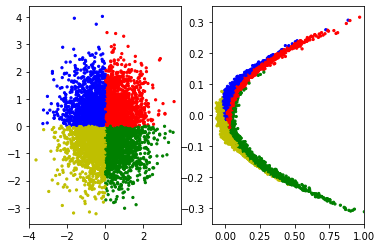

In [7]:
#XF = model.flow.sample(5000)
Z = np.random.normal(0,1,(5000,2))
cols = []
for i in range(5000):
    if (Z[i,0] > 0 and Z[i,1] > 0):
        cols.append('r')
    elif (Z[i,0] < 0 and Z[i,1] > 0):
        cols.append('b')
    elif (Z[i,0] < 0 and Z[i,1] < 0):
        cols.append('y')
    else:
        cols.append('g')

plt.subplot(1,2,1)
plt.scatter(Z[:, 0], Z[:, 1], s=5,c=cols)
plt.title('Z ~ N(0,1)')
Xs = model(Z)
plt.subplot(1,2,2)
plt.scatter(Xs[:,0], Xs[:, 1], s=5, c=cols)
plt.xlim(-5,40)
plt.ylim(-15,15)
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)

# Junk below

### Functional API not yet working
Did not get this API to work.

Using the function API
It's possible to use the functional API, since Distributions and Bijectors implement / subclass tf.Module. The variables are accessible via 'trainable_variables'

https://groups.google.com/a/tensorflow.org/forum/#!topic/tfprobability/jg6iXMD1Nw4

In [8]:
f = tfb.AffineScalar(shift=1, scale=3)
f.forward(2.0)
f.trainable_variables

()

In [9]:
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
from tensorflow.keras.models import Model
from tensorflow.keras import Input

# This returns a tensor
inputs = Input(shape=(784,))
output_dim=2
num_masked=1

shift_and_log_scale_fn = tfb.masked_autoregressive_default_template(hidden_layers=[128, 128])
# Defining the bijector
num_bijectors = 5
bijectors=[]
for i in range(num_bijectors):
    bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=shift_and_log_scale_fn))
    bijectors.append(tfb.Permute(permutation=[1, 0]))
# Discard the last Permute layer.
bijector = tfb.Chain(list(reversed(bijectors[:-1])))

# Defining the flow
flow = tfd.TransformedDistribution(
    distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]),
    bijector=bijector)

flow.bijector.forward(X[0:10])

model = Model(inputs=inputs, outputs=flow)

AttributeError: 'TransformedDistribution' object has no attribute 'op'

In [ ]:
inputs = Input(shape=(784,))
#model = Model(inputs=inputs, outputs=flow) is not possible

In [ ]:
# See also https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/bijectors/real_nvp.py
from pylab import *
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

class RealNVP(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, **kwargs): #** additional arguments for the super class
        super().__init__(**kwargs)
        self.output_dim = output_dim
        # Defining the bijector
        bijectors=[]
        
        h = 32
        self.n1 = tfb.real_nvp_default_template(hidden_layers=[h, h])
        bijectors.append(tfb.RealNVP(shift_and_log_scale_fn=self.n1,num_masked=num_masked))
        bijectors.append(tfb.Permute([1,0]))
        
        self.n2 = tfb.real_nvp_default_template(hidden_layers=[h, h])
        bijectors.append(tfb.RealNVP(shift_and_log_scale_fn=self.n2,num_masked=num_masked))
        bijectors.append(tfb.Permute([1,0]))
        
        self.n3 = tfb.real_nvp_default_template(hidden_layers=[h, h])
        bijectors.append(tfb.RealNVP(shift_and_log_scale_fn=self.n3,num_masked=num_masked))
        bijectors.append(tfb.Permute([1,0]))
        
        self.n4 = tfb.real_nvp_default_template(hidden_layers=[h, h])
        bijectors.append(tfb.RealNVP(shift_and_log_scale_fn=self.n4,num_masked=num_masked))
        bijectors.append(tfb.Permute([1,0]))
        
        self.n5 = tfb.real_nvp_default_template(hidden_layers=[h, h])
        bijectors.append(tfb.RealNVP(shift_and_log_scale_fn=self.n5,num_masked=num_masked))
        
# ------- Using Reflection ---    
#         for i in range(2):
#             #self.n1 = tfb.real_nvp_default_template(hidden_layers=[12, 12])
#             setattr(self,'dumm_{}'.format(i),tfb.real_nvp_default_template(hidden_layers=[12, 12]))
#             bijectors.append(tfb.RealNVP(shift_and_log_scale_fn=getattr(self,'dumm_{}'.format(i)), 
#                                          num_masked=num_masked))
#             bijectors.append(tfb.Permute(permutation=[1, 0]))
#        # Discard the last Permute layer.
#        bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        
        bijector = tfb.Chain(list(bijectors))
        # Defining the flow
        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]),
            bijector=bijector)

    def call(self, *inputs): 
        return self.flow.bijector.forward(*inputs)
    
    def getFlow(self, num):
        return self.flow.sample(num)

print(X.shape)
model = RealNVP(output_dim=2, num_masked=1)
#model.summary() #Yields an error. The model needs called before it is build.
_ = model(X) 
print(model.summary())
-tf.reduce_mean(model.flow.log_prob(X)) #Needs to be called other-wise @tf.function has problem